In [1]:
# calculations/order_parameter.py

import numpy as np
from ase import Atoms
from scipy.spatial import cKDTree

def calculate_order_parameter(structure: Atoms, center_type: int = 0, relative_type: int = 3) -> np.ndarray:
    """
    Calculate the order parameter for atoms of center_type by finding the
    minimum distance to the nearest symmetry-related positions of relative_type atoms.
    Only considers 2D positions (x and y coordinates).

    Parameters:
        structure (Atoms): The atomic structure.
        center_type (int): The atom type for which to calculate the order parameter.
        relative_type (int): The atom type to calculate the order parameter relative to.

    Returns:
        np.ndarray: Array of order parameters for center_type atoms.
    """
    positions = structure.get_positions()[:, :2]  # Only consider x and y coordinates
    atom_types = structure.arrays['atom_types']
    cell = structure.get_cell()[:2, :2]  # Only consider x and y components of cell vectors

    # Filter atom types
    center_indices = np.where(atom_types == center_type)[0]
    relative_indices = np.where(atom_types == relative_type)[0]

    center_positions = positions[center_indices]
    relative_positions = positions[relative_indices]

    # Define translation vectors for nearest neighbors and other symmetry-related shifts
    translation_vectors = np.array([
        [0, 0],
        cell[0], cell[1],
        cell[0] + cell[1],
        -cell[0], -cell[1],
        -cell[0] - cell[1]
    ])

    # Build KDTree for efficient nearest neighbor search
    tree = cKDTree(relative_positions)

    # Calculate nearest neighbor distances for all center atoms
    distances, _ = tree.query(center_positions, k=1)

    # Calculate symmetry-related distances using broadcasting
    symmetry_distances = np.linalg.norm(center_positions[:, None, None] - (relative_positions[None, :, None] + translation_vectors[None, None, :]), axis=-1)

    # Find minimum distances across all symmetry-related positions
    min_distances = np.min(symmetry_distances, axis=(1, 2))

    # Calculate order parameters as the difference between actual and ideal positions
    order_parameters = np.abs(min_distances)

    return order_parameters

# calculate_order_parameter(unrelaxed, 0, 3)



In [2]:
# calculations/disregistry.py

import numpy as np
from ase import Atoms

def mod_gamma(v, gamma_lattice):
    """Reduces a vector v modulo the lattice defined by gamma_lattice."""
    coeffs = np.linalg.solve(gamma_lattice.T, v)
    coeffs = coeffs % 1
    return np.dot(gamma_lattice.T, coeffs)

def unit_range_fixed(x, L=1, eps=1e-9):
    y = x.copy()
    y = y % L
    y[(np.fabs(y) < eps) | (np.fabs(L - y) < eps)] = 0
    return y

def calculate_disregistry(structure: Atoms, A1: np.ndarray, A2: np.ndarray) -> tuple:
    """
    Calculate disregistry vectors for atom_types == 0 and atom_types == 3 atoms
    with respect to the top and bottom layer primitive unit cells.

    Parameters:
        relaxed (Atoms): The relaxed atomic structure.
        A1 (np.ndarray): Primitive unit cell vectors for layer 1.
        A2 (np.ndarray): Primitive unit cell vectors for layer 2.

    Returns:
        tuple: (b1, b2) Disregistry vectors for atom_types == 3 and atom_types == 0 atoms.
    """
    positions = structure.get_positions()[:, :2]
    atom_types = structure.arrays['atom_types']

    ad1 = np.eye(2) - A2 @ np.linalg.inv(A1)
    ad2 = np.eye(2) - A1 @ np.linalg.inv(A2)
    
     

    layer1_mask = atom_types == 0
    layer2_mask = atom_types == 3

    b1 = (ad1 @ positions[layer1_mask].T).T
    b2 = (ad2 @ positions[layer2_mask].T).T

    # b1 = unit_range_fixed(b1 @ np.linalg.inv(A2)) @ A2
    # b2 = unit_range_fixed(b2 @ np.linalg.inv(A1)) @ A1

    return b1, b2

# Example usage:
b1_unrelaxed, b2_unrelaxed = calculate_disregistry(unrelaxed, A1.T, A2.T)
b1_relaxed, b2_relaxed = calculate_disregistry(relaxed, A1.T, A2.T)


NameError: name 'unrelaxed' is not defined

In [ ]:

unit_range_fixed(unrelaxed.get_positions()[unrelaxed.arrays['atom_types'] == 3,:2] @ np.linalg.inv(A2))

array([[0.        , 0.        ],
       [0.68333248, 0.92765981],
       [0.63516374, 0.85531962],
       [0.586995  , 0.78297943],
       [0.53882626, 0.71063924],
       [0.49065752, 0.63829905],
       [0.44248878, 0.56595886],
       [0.39432004, 0.49361867],
       [0.3461513 , 0.42127847],
       [0.29798256, 0.34893828],
       [0.24981382, 0.27659809],
       [0.20164508, 0.2042579 ],
       [0.15347634, 0.13191771],
       [0.1053076 , 0.05957752]])

In [42]:
periodic_2_unrelaxed = unit_range_fixed(unrelaxed.get_positions()[unrelaxed.arrays['atom_types'] == 0,:2] @ np.linalg.inv(A2)) @ A2
# periodic_2_relaxed = unit_range_fixed(relaxed.get_positions()[relaxed.arrays['atom_types'] == 3,:2] @ np.linalg.inv(A2.T)) @ A2.T

# periodic_2_unrelaxed = unrelaxed.get_positions()[unrelaxed.arrays['atom_types'] == 3,:2]
# periodic_2_relaxed = relaxed.get_positions()[relaxed.arrays['atom_types'] == 3,:2]

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# unrelaxed_positions = unrelaxed.positions[unrelaxed.arrays['atom_types'] == 0, :2]
# relaxed_positions = relaxed.positions[relaxed.arrays['atom_types'] == 0, :2]
# ad1 = np.eye(2) - A2.T @ np.linalg.inv(A1.T)
# b1_unrelaxed = (ad1 @ unrelaxed_positions.T).T
# b1_relaxed = (ad1 @ relaxed_positions.T).T

plt.figure(figsize=(10, 8))
plt.scatter(b2_unrelaxed[:,0], b2_unrelaxed[:,1])
plt.scatter(b2_relaxed[:,0], b2_relaxed[:,1])

# plt.scatter(periodic_2_unrelaxed[:,0], periodic_2_unrelaxed[:,1])
# plt.scatter(periodic_2_relaxed[:,0], periodic_2_relaxed[:,1])

# Add lines representing the unit cell A1 as a full polygon
origin = np.array([0, 0])
vertices = np.array([origin, A1[0], A1[0] + A1[1], A1[1], origin])
plt.plot(vertices[:, 0], vertices[:, 1], 'r-', linewidth=2, label='A1 unit cell')

plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Disregistry vectors with A1 unit cell')
plt.axis('equal')
plt.show()

NameError: name 'b2_unrelaxed' is not defined

<Figure size 1000x800 with 0 Axes>

In [5]:
n_points = 25

# Generate integer coordinates
x, y = np.meshgrid(range(0, n_points+1), range(0, n_points+1))
coords = np.stack((x.flatten(), y.flatten()), axis=-1)

lattice_points_1 = coords @ A1
lattice_points_2 = coords @ A2
lattice_points_2to1 = lattice_points_2 - lattice_points_2 @ np.linalg.inv(A2) @ A1
lattice_points_1to1 = lattice_points_1 - lattice_points_1 @ np.linalg.inv(A1) @ A1 + np.random.rand(len(lattice_points_1),2) @ A1


plt.scatter(lattice_points_1[:,0], lattice_points_1[:,1])   
plt.scatter(lattice_points_2[:,0], lattice_points_2[:,1])
plt.axis('scaled')

plt.figure(figsize=(10, 8))
plt.scatter(lattice_points_2to1[:,0], lattice_points_2to1[:,1],s = 10)
plt.scatter(lattice_points_1to1[:,0], lattice_points_1to1[:,1],s = 10)
#plotting the edges of the unit cell
plt.plot([0, A1[0,0]], [0, A1[0,1]], 'r-')
plt.plot([A1[0,0], A1[0,0]+A1[1,0]], [A1[0,1], A1[0,1]+A1[1,1]], 'r-')
plt.plot([A1[0,0]+A1[1,0], A1[1,0]], [A1[0,1]+A1[1,1], A1[1,1]], 'r-')
plt.plot([A1[1,0], 0], [A1[1,1], 0], 'r-')
plt.axis('scaled')

NameError: name 'A1' is not defined

In [121]:
import numpy as np
from scipy.spatial import cKDTree


def calculate_btilde(A1, A2, r2_A, r2_B, r1_A, r1_B):
    """
    Calculate b\tilde_{2->1} = b_{2->1} + u_2 - u_1
    
    Parameters:
    A1, A2: Lattice vectors for layers 1 and 2
    r2_A, r2_B: Positions for layer 2 in states A and B
    r1_A, r1_B: Positions for layer 1 in states A and B
    
    Returns:
    b\tilde_{2->1}
    """
    
    # Generate pristine lattice points
    n_points = max(len(r1_A), len(r2_A))
    x, y = np.meshgrid(range(int(np.sqrt(n_points))), range(int(np.sqrt(n_points))))
    coords = np.stack((x.flatten(), y.flatten()), axis=-1)
    
    lattice_points_2 = coords @ A2
    lattice_points_1 = coords @ A1
    
    # Calculate b_{2->1}
    b_2to1 = lattice_points_2 - lattice_points_2 @ np.linalg.inv(A2) @ A1
    
    # Calculate u_2
    tree_2 = cKDTree(lattice_points_2)
    _, indices_2A = tree_2.query(r2_A)
    _, indices_2B = tree_2.query(r2_B)
    u_2_A = r2_A - lattice_points_2[indices_2A]
    u_2_B = r2_B - lattice_points_2[indices_2B]
   
    # Calculate u_1
    tree_1 = cKDTree(lattice_points_1)
    _, indices_1A = tree_1.query(r1_A)
    _, indices_1B = tree_1.query(r1_B)
    u_1_A = r1_A - lattice_points_1[indices_1A]
    u_1_B = r1_B - lattice_points_1[indices_1B]
    
    # Calculate b_{2->1} + u_2
    b_plus_u2_A = b_2to1[indices_2A] + u_2_A
    b_plus_u2_B = b_2to1[indices_2B] + u_2_B
    
    # Find the nearest (b_{2->1} + u_2) vectors to u_1
    tree_u1 = cKDTree(b_plus_u2_A)
    _, indices_b_plus_u2_A = tree_u1.query(r1_A)
    tree_u1 = cKDTree(b_plus_u2_B)
    _, indices_b_plus_u2_B = tree_u1.query(r1_B)
    
    # Calculate b\tilde_{2->1}
    b_tilde_2to1_A = b_plus_u2_A[indices_b_plus_u2_A] - u_1_A
    b_tilde_2to1_B = b_plus_u2_B[indices_b_plus_u2_B] - u_1_B
    print(len(b_tilde_2to1_A))
    print(len(b_tilde_2to1_B))
    
    return b_tilde_2to1_A, b_tilde_2to1_B  # Using r2_A as positions for consistency


r2_A = unrelaxed.get_positions()[unrelaxed.arrays['atom_types'] == 3, :2]
r2_B = relaxed.get_positions()[relaxed.arrays['atom_types'] == 3, :2]
r1_A = unrelaxed.get_positions()[unrelaxed.arrays['atom_types'] == 0, :2]
r1_B = relaxed.get_positions()[relaxed.arrays['atom_types'] == 0, :2]

b_tilde_2to1_A, b_tilde_2to1_B = calculate_btilde(A1, A2, r2_A, r2_B, r1_A, r1_B)

# # Plot the results
# plt.figure(figsize=(10, 8))

# plt.quiver(r1_A[:, 0], r1_A[:, 1], 
#            b_tilde_2to1_A[:, 0], b_tilde_2to1_A[:, 1], 
#            angles='xy', scale_units='xy', scale=1, color='r', label='Layer 1')
# plt.quiver(r2_A[:, 0], r2_A[:, 1], 
#            b_tilde_2to1_B[:, 0], b_tilde_2to1_B[:, 1], 
#            angles='xy', scale_units='xy', scale=1, color='b', label='Layer 2')
# plt.scatter(r1_A[:, 0], r1_A[:, 1], s=20, color='red')
# plt.scatter(r2_A[:, 0], r2_A[:, 1], s=20, color='blue')
# plt.title('b\tilde_{2->1} vector field')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.axis('equal')
# plt.legend()
# plt.show()

# # Print some statistics about b_tilde_2to1
# print(f"Mean magnitude of b_tilde_2to1_A: {np.mean(np.linalg.norm(b_tilde_2to1_A, axis=1))}")
# print(f"Max magnitude of b_tilde_2to1_A: {np.max(np.linalg.norm(b_tilde_2to1_A, axis=1))}")
# print(f"Min magnitude of b_tilde_2to1_A: {np.min(np.linalg.norm(b_tilde_2to1_A, axis=1))}")

# print(f"Mean magnitude of b_tilde_2to1_B: {np.mean(np.linalg.norm(b_tilde_2to1_B, axis=1))}")
# print(f"Max magnitude of b_tilde_2to1_B: {np.max(np.linalg.norm(b_tilde_2to1_B, axis=1))}")
# print(f"Min magnitude of b_tilde_2to1_B: {np.min(np.linalg.norm(b_tilde_2to1_B, axis=1))}")


15
15


In [170]:
r2_A.shape

(14, 2)

(np.float64(-2.2509800000000038),
 np.float64(4.20558000000001),
 np.float64(-0.28469341319194175),
 np.float64(3.562052067294847))

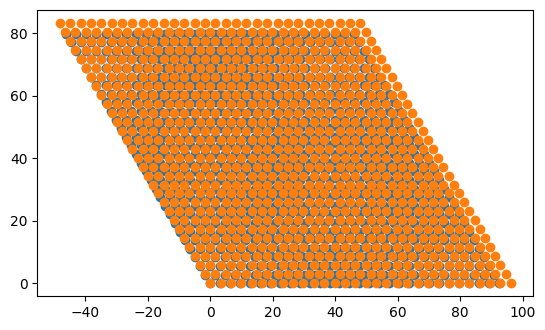

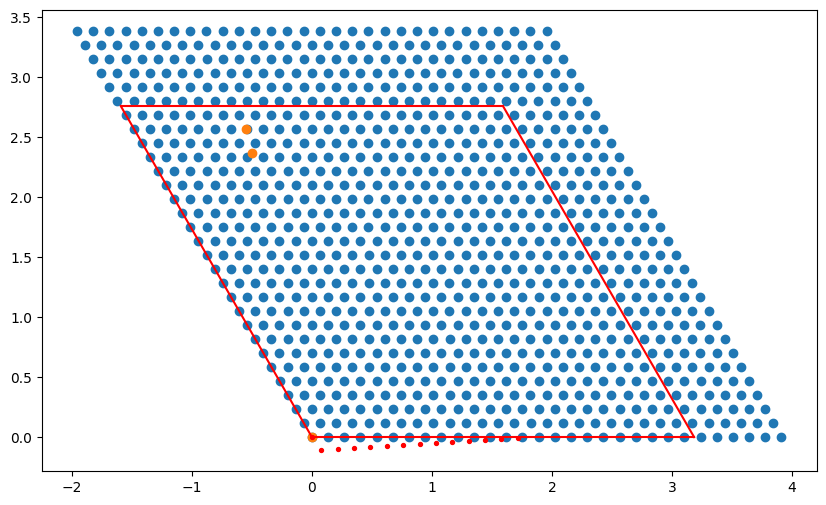

In [175]:
# Generate pristine lattice points
n_points = max(30, 30)
x, y = np.meshgrid(range(int(n_points)), range(int(n_points)))
coords = np.stack((x.flatten(), y.flatten()), axis=-1)

lattice_points_2 = coords @ A2
lattice_points_1 = coords @ A1

plt.scatter(lattice_points_1[:,0], lattice_points_1[:,1])
plt.scatter(lattice_points_2[:,0], lattice_points_2[:,1])
plt.axis('scaled')

# Calculate b_{2->1}
b_2to1 = lattice_points_2 - lattice_points_2 @ np.linalg.inv(A2) @ A1
offset_vector = np.array([0.5, 0.5]) @ A2
i = [15]
b_2to1_prime = (r2_A) - (r2_A) @ np.linalg.inv(A2) @ A1
offset_vector = np.array([.5, 0]) @ A1
b_1to1 = unit_range_fixed((r1_A) @ np.linalg.inv(A1)) @ A1
# disreg = b_2to1_prime - b_1to1

# # Calculate u_2
# tree_2 = cKDTree(lattice_points_2)
# _, indices_2A = tree_2.query(r2_A)
# _, indices_2B = tree_2.query(r2_B)
# u_2_A = r2_A - lattice_points_2[indices_2A]
# u_2_B = r2_B - lattice_points_2[indices_2B]

# print(u_2_A)
   

# b_plus_u2_A = u_2_A + b_2to1[indices_2A]
# b_plus_u2_B = u_2_B + b_2to1[indices_2B]


plt.figure(figsize=(10, 8))
plt.scatter(b_2to1[:,0], b_2to1[:,1])
plt.scatter(b_1to1[:3,0], b_1to1[:3,1])
# plt.scatter(disreg[:,0],disreg[:,1],s = 8, c= 'r')
plt.scatter(b_2to1_prime[:,0], b_2to1_prime[:,1],s = 8, c= 'r')
plt.plot([0, A1[0,0]], [0, A1[0,1]], 'r-')
plt.plot([A1[0,0], A1[0,0]+A1[1,0]], [A1[0,1], A1[0,1]+A1[1,1]], 'r-')
plt.plot([A1[0,0]+A1[1,0], A1[1,0]], [A1[0,1]+A1[1,1], A1[1,1]], 'r-')
plt.plot([A1[1,0], 0], [A1[1,1], 0], 'r-')
plt.axis('scaled')
plt.axis('scaled')

In [167]:
b_2to1_prime - b_1to1[0]

array([[0.46515, 0.0584 ]])

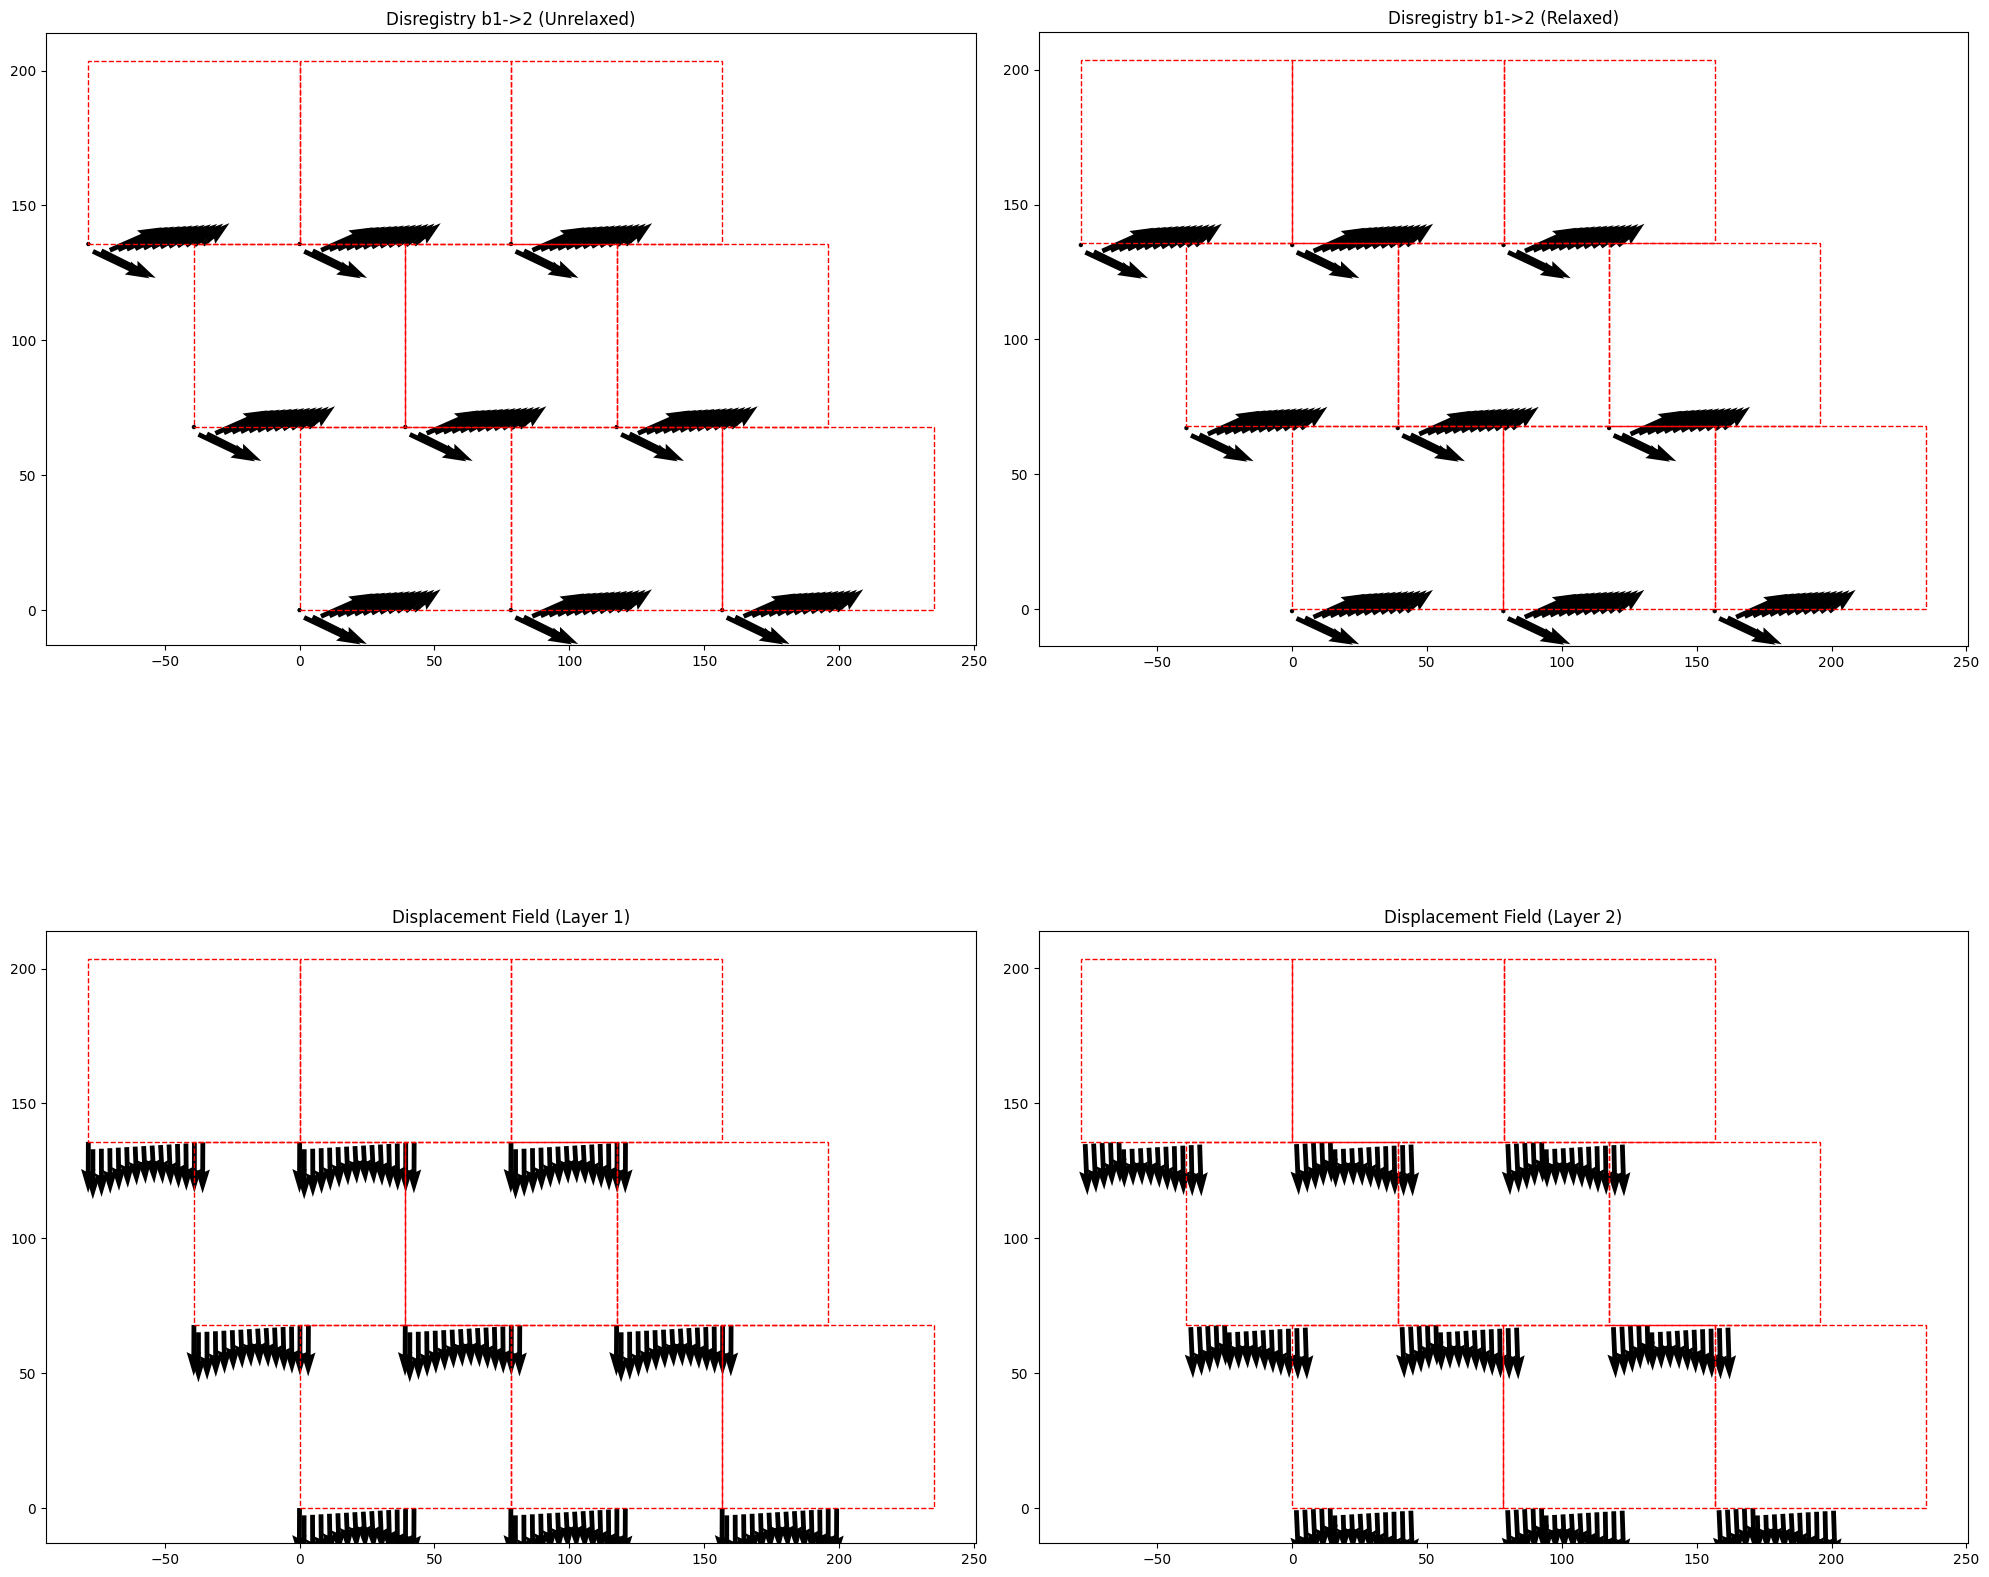

Moiré cell:
[[ 78.33971757   0.        ]
 [-39.13958585  67.85858091]]
Implicit Moire Cell:
Cell([[45.57485256139098, 3.552713678800501e-15, 0.0], [-1.448676469834382, -2.9109837489177366, 0.0], [0.0, 0.0, 31.88566545]])


In [49]:
import numpy as np
from ase import Atoms
from ase.geometry import find_mic

def calculate_disregistry(positions1, positions2, A1, A2):
    """
    Calculate disregistry between two layers using the interpolation formula.
    
    positions1, positions2: atomic positions of layers 1 and 2
    A1, A2: lattice matrices of layers 1 and 2
    """
    I = np.eye(2)  # 3x3 identity matrix
    b1to2 = []
    b2to1 = []
    
    for x in positions1:
        # Calculate b1->2
        b = (I - A2 @ np.linalg.inv(A1)) @ x
        b1to2.append(b - A2 @ np.floor(np.linalg.inv(A2) @ b))  # mod operation
    
    for x in positions2:
        # Calculate b2->1
        b = (I - A1 @ np.linalg.inv(A2)) @ x
        b2to1.append(b - A1 @ np.floor(np.linalg.inv(A1) @ b))  # mod operation
    
    return np.array(b1to2), np.array(b2to1)

def get_moire_cell(A1, A2):
    """Calculate moiré cell from layer primitive cells."""
    return np.linalg.inv(np.linalg.inv(A1) - np.linalg.inv(A2))

def extract_layer_positions(structure, atom_types, layer_index):
    """Extract positions of atoms in a specific layer."""
    return structure.get_positions()[structure.arrays['atom_types'] == atom_types[layer_index], :2]

def calculate_displacement(relaxed, unrelaxed):
    """Calculate displacement field between two layers."""
    return relaxed - unrelaxed
def analyze_and_plot(unrelaxed, relaxed, A1, A2, atom_types):
    # Extract layer positions
    layer1_unrelaxed = extract_layer_positions(unrelaxed, atom_types, 0)
    layer2_unrelaxed = extract_layer_positions(unrelaxed, atom_types, 1)
    layer1_relaxed = extract_layer_positions(relaxed, atom_types, 0)
    layer2_relaxed = extract_layer_positions(relaxed, atom_types, 1)

    # Calculate moiré cell
    moire_cell = get_moire_cell(A1, A2)

    # Calculate disregistries
    b1to2_unrelaxed, b2to1_unrelaxed = calculate_disregistry(layer1_unrelaxed, layer2_unrelaxed, A1, A2)
    b1to2_relaxed, b2to1_relaxed = calculate_disregistry(layer1_relaxed, layer2_relaxed, A1, A2)

    # Calculate displacement fields
    displacement_layer1 = calculate_displacement(layer1_relaxed, layer1_unrelaxed)
    displacement_layer2 = calculate_displacement(layer2_relaxed, layer2_unrelaxed)

    # Create 3x3 supercell
    def create_supercell(positions, vectors):
        supercell = []
        for i in range(3):
            for j in range(3):
                offset = i * vectors[0] + j * vectors[1]
                supercell.append(positions + offset)
        return np.vstack(supercell)

    # Create 3x3 supercells
    layer1_unrelaxed_super = create_supercell(layer1_unrelaxed, moire_cell)
    layer2_unrelaxed_super = create_supercell(layer2_unrelaxed, moire_cell)
    layer1_relaxed_super = create_supercell(layer1_relaxed, moire_cell)
    layer2_relaxed_super = create_supercell(layer2_relaxed, moire_cell)

    # Extend disregistries and displacement fields
    b1to2_unrelaxed_super = np.tile(b1to2_unrelaxed, (9, 1))
    b1to2_relaxed_super = np.tile(b1to2_relaxed, (9, 1))
    displacement_layer1_super = np.tile(displacement_layer1, (9, 1))
    displacement_layer2_super = np.tile(displacement_layer2, (9, 1))

    # Plot results
    fig, axs = plt.subplots(2, 2, figsize=(20, 20))

    # Plot disregistry b1->2 for unrelaxed structure
    axs[0, 0].quiver(layer1_unrelaxed_super[:, 0], layer1_unrelaxed_super[:, 1], 
                     b1to2_unrelaxed_super[:, 0], b1to2_unrelaxed_super[:, 1])
    axs[0, 0].set_title('Disregistry b1->2 (Unrelaxed)')
    axs[0, 0].set_aspect('equal')

    # Plot disregistry b1->2 for relaxed structure
    axs[0, 1].quiver(layer1_relaxed_super[:, 0], layer1_relaxed_super[:, 1], 
                     b1to2_relaxed_super[:, 0], b1to2_relaxed_super[:, 1])
    axs[0, 1].set_title('Disregistry b1->2 (Relaxed)')
    axs[0, 1].set_aspect('equal')

    # Plot displacement field for layer 1
    axs[1, 0].quiver(layer1_unrelaxed_super[:, 0], layer1_unrelaxed_super[:, 1], 
                     displacement_layer1_super[:, 0], displacement_layer1_super[:, 1])
    axs[1, 0].set_title('Displacement Field (Layer 1)')
    axs[1, 0].set_aspect('equal')

    # Plot displacement field for layer 2
    axs[1, 1].quiver(layer2_unrelaxed_super[:, 0], layer2_unrelaxed_super[:, 1], 
                     displacement_layer2_super[:, 0], displacement_layer2_super[:, 1])
    axs[1, 1].set_title('Displacement Field (Layer 2)')
    axs[1, 1].set_aspect('equal')

    # Add moiré cell outlines
    for ax in axs.flat:
        for i in range(3):
            for j in range(3):
                offset = i * moire_cell[0] + j * moire_cell[1]
                rect = plt.Rectangle(offset, moire_cell[0, 0], moire_cell[1, 1], 
                                     fill=False, color='red', linestyle='--')
                ax.add_patch(rect)

    plt.tight_layout()
    plt.show()

    # Print moiré cell
    print("Moiré cell:")
    print(moire_cell)
    
    print("Implicit Moire Cell:")
    print(unrelaxed.cell)

    
# # Define A1 and A2 unit cells (replace with your actual unit cell matrices)
def convert_string_to_array(string):
    # Remove brackets and split the string into components
    return np.array([float(x) for x in string.strip('[]').split()]).reshape(2,2)
A1 = convert_string_to_array(unrelaxed.info['base_lattice_0'])
A2 = convert_string_to_array(unrelaxed.info['base_lattice_1'])

analyze_and_plot(unrelaxed, relaxed, A1, A2, unrelaxed.arrays['atom_types'])

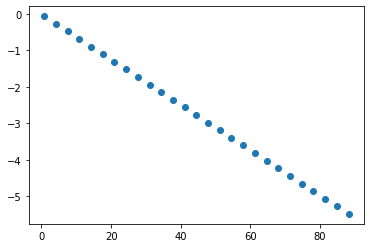

In [75]:
# (unrelaxed.get_positions()[unrelaxed.arrays['atom_types'] == 3,:2] @ np.linalg.inv(A2)) @ A2
np.set_printoptions(precision=2, suppress=True)
# plt.scatter(unrelaxed.get_positions()[unrelaxed.arrays['atom_types'] == 0,:2] @ np.linalg.inv(A1))
plt.scatter(unrelaxed.get_positions()[unrelaxed.arrays['atom_types'] == 3,0], unrelaxed.get_positions()[unrelaxed.arrays['atom_types'] == 3,1])


In [6]:
def plot_order_parameter_along_spline(relaxed: Atoms, order_parameter: np.ndarray, num_points: int = 1000):
    """
    Plot the order parameter along a cubic spline path through atom_types == 0 atoms,
    with the line colored according to the magnitude of the order parameter.

    Parameters:
        relaxed (Atoms): The relaxed atomic structure.
        order_parameter (np.ndarray): Array of order parameters.
        num_points (int): Number of points to interpolate along the spline.
    """
    positions = relaxed.get_positions()
    atom_types = relaxed.arrays['atom_types']
    
    # Filter atom_types == 0
    type0_indices = np.where(atom_types == 0)[0]
    type0_positions = positions[type0_indices]
    type0_order_param = order_parameter
    
    # Sort atoms by x-coordinate to create a path
    sorted_indices = np.argsort(type0_positions[:, 0])
    sorted_positions = type0_positions[sorted_indices]
    sorted_order_param = type0_order_param[sorted_indices]
    
    # Calculate atom distances
    atom_distances = np.cumsum(np.sqrt(np.sum(np.diff(sorted_positions, axis=0)**2, axis=1)))
    atom_distances = np.insert(atom_distances, 0, 0)  # Add starting point
    
    # Create cubic spline through atom positions
    tck, u = splprep([sorted_positions[:, 0], sorted_positions[:, 1]], s=0, k=3)
    
    # Interpolate points along the spline
    spline_points = np.linspace(0, 1, num_points)
    interpolated_positions = np.array(splev(spline_points, tck)).T
    
    # Calculate cumulative distance along the spline
    distances = np.cumsum(np.sqrt(np.sum(np.diff(interpolated_positions, axis=0)**2, axis=1)))
    distances = np.insert(distances, 0, 0)  # Add starting point
    
    # Create RBF interpolation for order parameter
    rbf = Rbf(sorted_positions[:, 0], sorted_positions[:, 1], sorted_order_param, function='multiquadric')
    interpolated_order_param = rbf(interpolated_positions[:, 0], interpolated_positions[:, 1])
    
    # Plot
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Plot interpolated order parameter with color
    points = ax1.scatter(distances, interpolated_order_param, c=interpolated_order_param, cmap='viridis', s=5, vmin=0, vmax=1.8)
    fig.colorbar(points, ax=ax1, label='Order Parameter')
    
    # Plot actual values
    ax1.scatter(atom_distances, sorted_order_param, color='red', s=30, zorder=3, label='Actual Values')
    
    ax1.set_ylim(0, 1.8)
    ax1.set_xlabel('Distance along path (Å)')
    ax1.set_ylabel('Order Parameter')
    ax1.legend()
    
    # Create secondary x-axis for atom positions
    ax2 = ax1.twiny()
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(atom_distances)
    ax2.set_xticklabels([])
    
    # Add vertical lines for atom positions
    for dist in atom_distances:
        ax1.axvline(x=dist, color='gray', alpha=0.3, linestyle='--')
    
    plt.title('Order Parameter Along Cubic Spline Path')
    
    plt.tight_layout()
    plt.show()

# Usage example:
plot_order_parameter_along_spline(relaxed, relaxed_order_param)
plot_order_parameter_along_spline(unrelaxed, unrelaxed_order_param)

NameError: name 'relaxed_order_param' is not defined

In [7]:
def plot_order_parameter_top_down(relaxed: Atoms, order_parameter: np.ndarray, grid_size: int = 200):
    """
    Plot a top-down view of the lattice with interpolated order parameter as background
    and vertical gray lines at each atom's x-position.

    Parameters:
        relaxed (Atoms): The relaxed atomic structure.
        order_parameter (np.ndarray): Array of order parameters.
        grid_size (int): Resolution of the interpolation grid.
    """
    positions = relaxed.get_positions()
    atom_types = relaxed.arrays['atom_types']
    
    # Filter atom_types == 0
    type0_indices = np.where(atom_types == 0)[0]
    type0_positions = positions[type0_indices]
    type0_order_param = order_parameter
    
    x, y = type0_positions[:, 0], type0_positions[:, 1]
    
    # RBF interpolation
    rbf = Rbf(x, y, type0_order_param, function='multiquadric', smooth=0.1)
    xi = np.linspace(x.min(), x.max(), grid_size)
    yi = np.linspace(y.min(), y.max(), grid_size)
    xi, yi = np.meshgrid(xi, yi)
    zi = rbf(xi, yi)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(zi, extent=(x.min(), x.max(), y.min(), y.max()), origin='lower', cmap='viridis', alpha=0.6, vmin=0, vmax=1.8)
    plt.colorbar(im, label='Order Parameter', fraction=0.01, pad=0.04)
    
    # Plot atom_types == 0 atoms
    ax.scatter(type0_positions[:, 0], type0_positions[:, 1], c='red', s=10, label='Type 0 Atoms')
    
    # Add vertical gray lines at each atom's x-position
    for x_pos in type0_positions[:, 0]:
        ax.axvline(x=x_pos, color='gray', alpha=0.3, linestyle='--')
    
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_title('Top-Down View of Order Parameter')
    ax.legend()
    plt.tight_layout()
    plt.show()

# Example usage
plot_order_parameter_top_down(relaxed, relaxed_order_param)
plot_order_parameter_top_down(unrelaxed, unrelaxed_order_param)

NameError: name 'Rbf' is not defined

In [3]:
# plots/disregistry_plots.py

import numpy as np
import matplotlib.pyplot as plt

def plot_disregistry_scatter(disregistry: np.ndarray):
    """
    Plot a scatter plot of disregistry vectors on the configuration space grid.

    Parameters:
        disregistry (np.ndarray): Disregistry vectors for atom_types == 0 atoms.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(disregistry[:, 0], disregistry[:, 1], c='blue', s=10, alpha=0.6)
    plt.xlabel('Displacement along A2[0]')
    plt.ylabel('Displacement along A2[1]')
    plt.title('Disregistry Scatter Plot')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
# example usage
plot_disregistry_scatter(b1_unrelaxed)
plot_disregistry_scatter(b1_relaxed)

NameError: name 'b1_unrelaxed' is not defined

In [6]:
# main.py

import numpy as np
from ase.io import read
# from calculations.order_parameter import calculate_order_parameter
# from calculations.disregistry import calculate_disregistry
# from plots.order_parameter_plots import plot_order_parameter_cut, plot_order_parameter_top_down
# from plots.disregistry_plots import plot_disregistry_scatter


# File paths (replace with your actual file paths)
unrelaxed_file = 'MoS2_WSe2_1D.xyz'
relaxed_file = 'MoS2_WSe2_1D_lammps.traj.xyz'

# Read structures
unrelaxed = read(unrelaxed_file, index= 0)
relaxed = read(relaxed_file, index= -1)
relaxed.arrays['atom_types'] = unrelaxed.arrays['atom_types']

# # Calculate order parameter
unrelaxed_order_param = calculate_order_parameter(unrelaxed, 0, 3)
relaxed_order_param = calculate_order_parameter(relaxed, 0, 3)

# # Plot order parameter cut along x-axis (axis=0)
# plot_order_parameter_along_spline(unrelaxed, unrelaxed_order_param)
# plot_order_parameter_along_spline(relaxed, relaxed_order_param)

# # # Plot top-down view of order parameter
# plot_order_parameter_top_down(unrelaxed, unrelaxed_order_param)
# plot_order_parameter_top_down(relaxed, relaxed_order_param)

# # Define A1 and A2 unit cells (replace with your actual unit cell matrices)
def convert_string_to_array(string):
    # Remove brackets and split the string into components
    return np.array([float(x) for x in string.strip('[]').split()]).reshape(2,2)
A1 = convert_string_to_array(unrelaxed.info['base_lattice_0'])
A2 = convert_string_to_array(unrelaxed.info['base_lattice_1'])

# # Calculate disregistry vectors
disregistry_relaxed = calculate_disregistry(relaxed, A1, A2)
disregistry_unrelaxed = calculate_disregistry(unrelaxed, A1, A2)

# # Plot disregistry scatter
# plot_disregistry_scatter(disregistry)

In [7]:
disregistry_relaxed

(array([[ 1.39018896e-04,  3.01213706e-02],
        [-1.79788489e+00,  3.91662736e-02],
        [-1.66519794e+00,  4.65419941e-02],
        [-1.53267677e+00,  5.33078968e-02],
        [-1.40025868e+00,  5.97193292e-02],
        [-1.26781519e+00,  6.61461593e-02],
        [-1.13522279e+00,  7.29489920e-02],
        [-1.00242991e+00,  8.03675476e-02],
        [-8.69468609e-01,  8.84825941e-02],
        [-7.36417354e-01,  9.72430623e-02],
        [-6.03353241e-01,  1.06511726e-01],
        [-4.70321490e-01,  1.16099939e-01],
        [-3.37329403e-01,  1.25797525e-01],
        [-2.04361337e-01,  1.35385713e-01],
        [-7.14070071e-02,  1.44648764e-01]]),
 array([[ 3.19363049e-04,  3.44106668e-02],
        [ 1.71620790e+00,  2.48467000e-02],
        [ 1.57946366e+00,  1.55403220e-02],
        [ 1.44247155e+00,  5.77268377e-03],
        [ 1.30537268e+00, -4.15493558e-03],
        [ 1.16838435e+00, -1.38887003e-02],
        [ 1.03166223e+00, -2.31463984e-02],
        [ 8.95223512e-01, -3.1

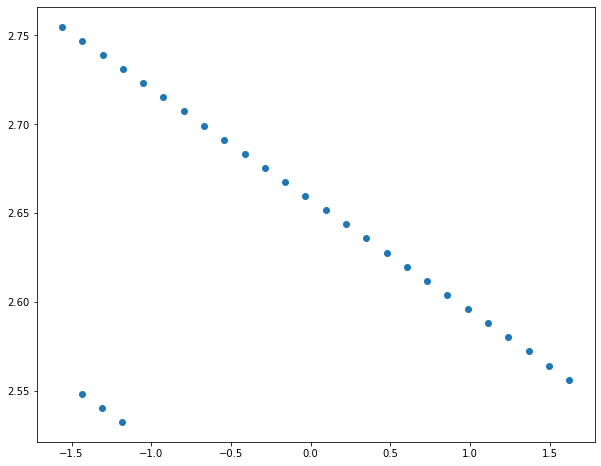

In [26]:
%matplotlib inline
plt.figure(figsize=(10, 8))
plt.scatter(disregistry_unrelaxed[1][:,0], disregistry_unrelaxed[1][:,1])


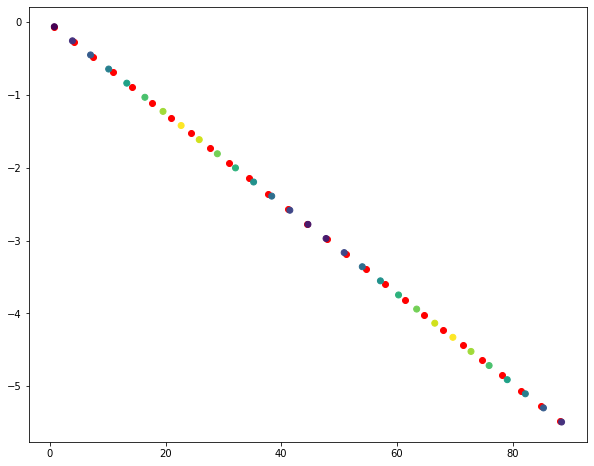

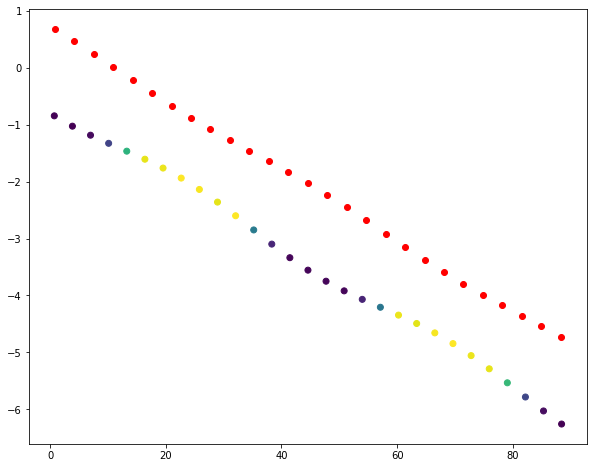

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10, 8))
plt.scatter(unrelaxed.get_positions()[unrelaxed.arrays['atom_types'] == 3, 0],
            unrelaxed.get_positions()[unrelaxed.arrays['atom_types'] == 3, 1], c='red')
plt.scatter(unrelaxed.get_positions()[unrelaxed.arrays['atom_types'] == 0, 0],
            unrelaxed.get_positions()[unrelaxed.arrays['atom_types'] == 0, 1], c=unrelaxed_order_param)

plt.figure(figsize=(10, 8))
plt.scatter(relaxed.get_positions()[relaxed.arrays['atom_types'] == 3, 0],
            relaxed.get_positions()[relaxed.arrays['atom_types'] == 3, 1], c='red')
plt.scatter(relaxed.get_positions()[relaxed.arrays['atom_types'] == 0, 0],
            relaxed.get_positions()[relaxed.arrays['atom_types'] == 0, 1], c=relaxed_order_param)


array([[ 8.84107336e+01, -6.25800084e+00,  2.77075868e+01],
       [ 4.15532954e+01, -1.48173163e+00,  2.92551172e+01],
       [ 4.15589947e+01, -1.47727083e+00,  2.61538929e+01],
       [ 8.52853648e+01, -6.02825915e+00,  2.77018858e+01],
       [ 3.84294924e+01, -1.24251882e+00,  2.92517087e+01],
       [ 3.84286823e+01, -1.23860683e+00,  2.61505327e+01],
       [ 8.21609998e+01, -5.78323358e+00,  2.77027244e+01],
       [ 3.53109630e+01, -9.92638020e-01,  2.92587911e+01],
       [ 3.52971052e+01, -9.89937660e-01,  2.61576054e+01],
       [ 7.90361776e+01, -5.53365440e+00,  2.77166314e+01],
       [ 3.21918123e+01, -7.41732370e-01,  2.92799281e+01],
       [ 3.21651485e+01, -7.41073620e-01,  2.61791569e+01],
       [ 7.59079887e+01, -5.28784923e+00,  2.77438311e+01],
       [ 7.42912702e+01, -6.12093408e+00,  2.93089347e+01],
       [ 7.42632582e+01, -6.12294321e+00,  2.62086349e+01],
       [ 7.27752184e+01, -5.05595814e+00,  2.77723032e+01],
       [ 7.11531923e+01, -5.89705056e+00